## Housing Data Analysis

### Importing Data

In [19]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [2]:
DOWNLOAD_ROOT= "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

In [3]:
def fetch_housing_data(housing_url= HOUSING_URL, housing_path= HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path= os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path= housing_path)
    housing_tgz.close()
    

In [4]:
def load_housing_data(housing_path= HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)

## First Preview of Data

In [5]:
housing_df = load_housing_data()
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Information on Features

In [6]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Basic Summary of Features

In [7]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x109184e10>,
      dtype=object)

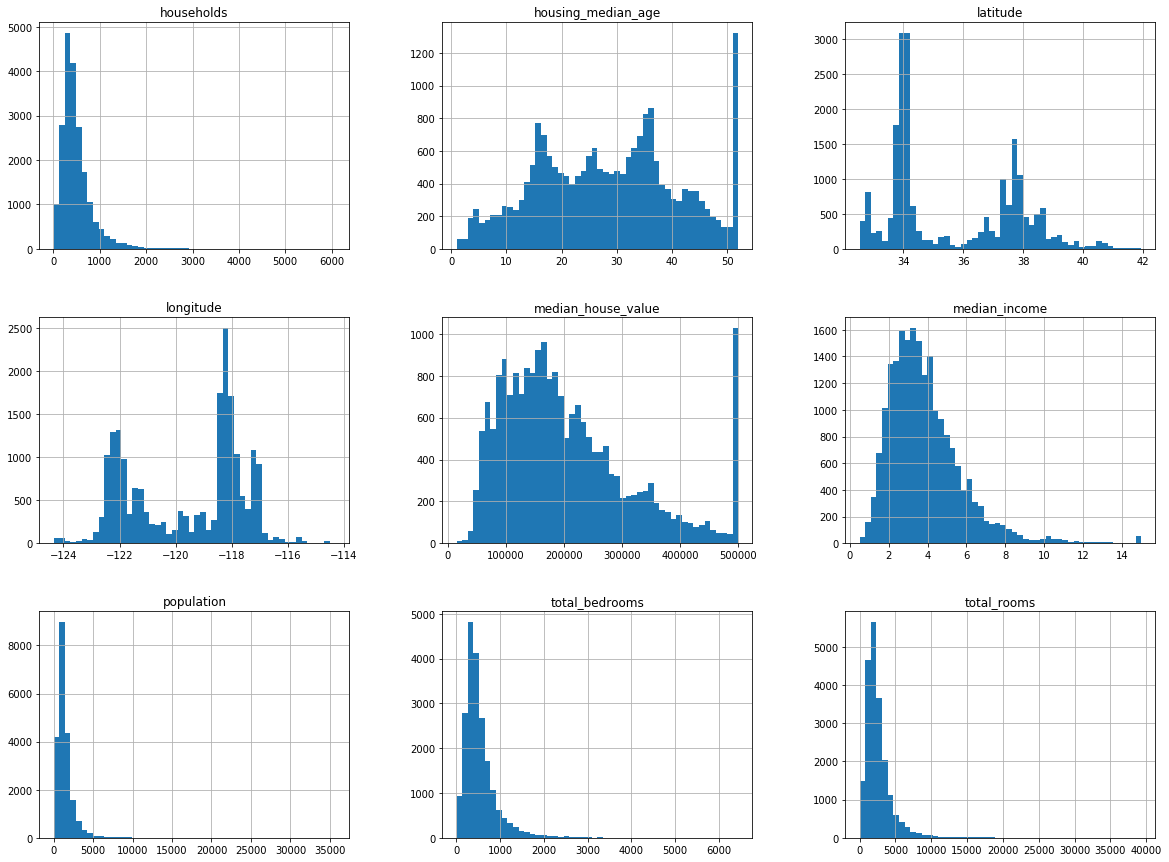

In [8]:
%matplotlib inline 
housing_df.hist(bins= 50, figsize =(20,15))

### Splitting the data

In [9]:
def split_train_test(data,test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(test_ratio * len(data))
    train_data = data.iloc[shuffled_indices[test_size:]]
    test_data = data.iloc[shuffled_indices[:test_size]]
    return train_data,test_data

In [10]:
test_ratio = 0.2
train_data,test_data = split_train_test(housing_df,0.2)
print(len(train_data),len(test_data))

16512 4128


In [11]:
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(housing_df,test_size =0.2,random_state = 42)

### Stratified Splitting of the Data

The data will be stratified on the basis of median income

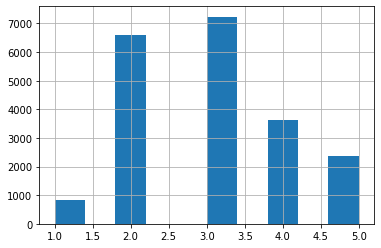

In [12]:
housing_df["income_cat"] = pd.cut(housing_df["median_income"],bins = [0,1.5,3,4.5,6,np.inf],labels = [1,2,3,4,5])
housing_df["income_cat"].hist()

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)

for strat_train_indices,strat_test_indices in sss.split(X = housing_df,y =housing_df["income_cat"]):
    strat_train_data = housing_df.loc[strat_train_indices]
    strat_test_data = housing_df.loc[strat_test_indices]

for set_ in(strat_train_data, strat_test_data):
    set_.drop("income_cat",axis = 1 , inplace =True)


## Visualizing the Data

In [14]:
housing_copy = strat_train_data.copy()  #Create a copy of the dataframe

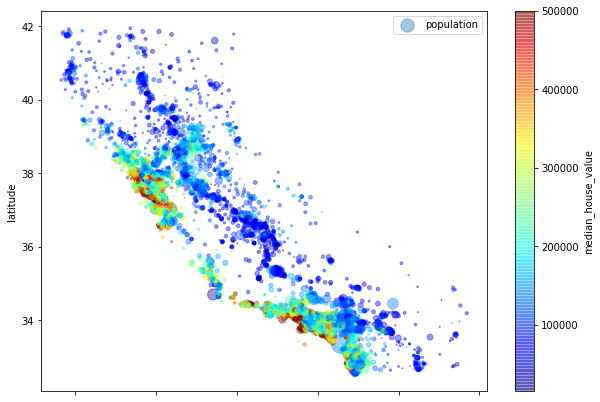

In [15]:
housing_copy.plot(kind= 'scatter', x= "longitude", y= "latitude", alpha = 0.4, s= housing_copy["population"]/100,
                 c= "median_house_value", cmap= plt.get_cmap("jet"), colorbar= True, label="population",
                 figsize= (10,7))
plt.legend()

### Correlation 

In [16]:
corr_matrix = housing_copy.corr()
corr_matrix["median_house_value"].sort_values(ascending= False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

### Creating more useful variables

In [17]:
housing_copy["rooms_per_household"]= housing_copy["total_rooms"]/housing_copy["households"]
housing_copy["population_per_household"]= housing_copy["population"]/housing_copy["households"]
housing_copy["bedroom_room_ratio"]= housing_copy["total_bedrooms"]/housing_copy["total_rooms"]

### Checking new correlation matrix

In [18]:
corr_matrix = housing_copy.corr()
corr_matrix["median_house_value"].sort_values(ascending= False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedroom_room_ratio         -0.259984
Name: median_house_value, dtype: float64

## Data Cleaning

In [24]:
imputer = SimpleImputer(strategy='median')
housing_copy_numerical = housing_copy.drop(columns="ocean_proximity")
imputer.fit(housing_copy_numerical)
housing_train= pd.DataFrame(imputer.transform(housing_copy_numerical),columns= housing_copy_numerical.columns)